In [1]:
%load_ext rpy2.ipython

from fig_builder import TwinsFiguresData, TwinsFigures
from fig_builder import umap
from plotnine import *
import pandas as pd
import warnings
from random import shuffle


warnings.filterwarnings('ignore')

fig_data = TwinsFiguresData()
figs = TwinsFigures(fig_data)

In [72]:
meta = figs.metadata()
# meta['kind'] = meta['kind'].map(lambda x: 'oral' if x in ['buccal', 'saliva'] else x)
taxa = figs.twins.taxa_read_counts()
meta

,date,pma_treated,kind,subject,flight,during_flight,time_label
011515_TW_B,2015-01-15,False,buccal,TW,before,before,before
011515_TW_S,2015-01-15,False,saliva,TW,before,before,before
012015_HR_B,2015-01-20,False,buccal,HR,ground,before,before
012015_HR_S,2015-01-20,False,saliva,HR,ground,before,before
012016_HR_B,2016-01-20,False,buccal,HR,ground,flight,flight
...,...,...,...,...,...,...,...
IIIF3SW,2016-05-06,False,Surface,ISS,NaN,NaN,unknown
IIIF8SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown
IIIF5SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown
IIIF3SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown


In [124]:
a = meta.query('subject == "TW"').query('kind == "saliva"').sort_values('date')
a

,date,pma_treated,kind,subject,flight,during_flight,time_label
011515_TW_S,2015-01-15,False,saliva,TW,before,before,before
012715_TW_S,2015-01-27,False,saliva,TW,before,before,before
041015_TW_S,2015-04-10,False,saliva,TW,flight,flight,flight
091115_TW_S,2015-09-11,False,saliva,TW,flight,flight,flight
121015_TW_S,2015-12-10,False,saliva,TW,flight,flight,flight
030116_TW_S,2016-03-01,False,saliva,TW,flight,flight,flight
040616_TW_S,2016-04-06,False,saliva,TW,after,after,after
061416_TW_S,2016-06-14,False,saliva,TW,after,after,after
090816_TW_S,2016-09-08,False,saliva,TW,after,after,after


In [128]:
taxa.loc[a.index.to_list()].sum(axis=1)

011515_TW_S     57903489.0
012715_TW_S     75246862.0
041015_TW_S     59257176.0
091115_TW_S     91271090.0
121015_TW_S            0.0
030116_TW_S            0.0
040616_TW_S     84354588.0
061416_TW_S    100974369.0
090816_TW_S            0.0
dtype: float64

In [130]:

def new_taxa(order, taxa):
    out = {}
    current_taxa = set()
    for i, sample_name in enumerate(order):
        try:
            sample_taxa = taxa.loc[sample_name]
        except KeyError:
            continue
        sample_taxa = set(sample_taxa[sample_taxa > 0].index.to_list())
        new_taxa = sample_taxa - current_taxa
        current_taxa |= sample_taxa
        out[i] = len(new_taxa)
    return out


tw_real_order = meta.query('subject == "TW"').query('kind == "fecal"')['date'].sort_values().index.to_list()
new_taxa(tw_real_order, taxa)

{0: 7956, 1: 288, 2: 161, 3: 114, 4: 78, 5: 51, 6: 48, 7: 46, 8: 49}

In [149]:
def get_new_taxa_tbl(subject, kind, taxa):
    tw_real_order = meta.query('subject == @subject').query('kind == @kind')['date'].sort_values().index.to_list()
    tw_real_order = [el for el in tw_real_order if el in taxa.index]
    sample_names = dict(enumerate(tw_real_order))
    real_order = new_taxa(tw_real_order, taxa)
    new_taxa_tbl = {'Real Order': real_order, 'sample_name': sample_names}
    for i in range(1000):
        shuffle(tw_real_order)
        new_taxa_tbl[f'permutation_{i}'] = new_taxa(tw_real_order, taxa)

    new_taxa_tbl = pd.DataFrame.from_dict(new_taxa_tbl, orient='columns')
    new_taxa_tbl['numeric_order'] = new_taxa_tbl.index
    new_taxa_tbl = new_taxa_tbl.query('numeric_order > 0')
    dates = meta.query('subject == @subject').query('kind == @kind')['date']
    new_taxa_tbl['order'] = new_taxa_tbl['sample_name'].map(lambda x: dates[x])
    new_taxa_tbl['order'] = new_taxa_tbl['order'].map(str)
    #new_taxa_tbl['order'] = pd.Categorical(new_taxa_tbl['order'])
    new_taxa_tbl = new_taxa_tbl.melt(id_vars=['order', 'numeric_order', 'sample_name'])
    new_taxa_tbl['ovariable'] = new_taxa_tbl['variable']
    new_taxa_tbl['variable'] = new_taxa_tbl['variable'].map(lambda x: x.split('_')[0] if 'permutation' in x else x)
    new_taxa_tbl['subject'] = subject
    new_taxa_tbl['kind'] = kind
    new_taxa_tbl = new_taxa_tbl.dropna()
    return new_taxa_tbl
    
new_taxa_tbls = [
    get_new_taxa_tbl('TW', 'fecal', taxa),
    #get_new_taxa_tbl('TW', 'buccal', taxa),
    get_new_taxa_tbl('TW', 'saliva', taxa),
    get_new_taxa_tbl('HR', 'fecal', taxa),
    #get_new_taxa_tbl('HR', 'buccal', taxa),
    get_new_taxa_tbl('HR', 'saliva', taxa),
]
new_taxa_tbl = pd.concat(new_taxa_tbls)
new_taxa_tbl

#get_new_taxa_tbl('TW', 'saliva', taxa)

,order,numeric_order,sample_name,variable,value,ovariable,subject,kind
0,2015-01-16 00:00:00,1,MHV-TW2_S41668201,Real Order,288,Real Order,TW,fecal
1,2015-04-07 00:00:00,2,MHV-TW3_S41666352,Real Order,161,Real Order,TW,fecal
2,2015-06-24 00:00:00,3,MHV-TW5_S41659412,Real Order,114,Real Order,TW,fecal
3,2015-09-21 00:00:00,4,MHV-TW6_S41671226,Real Order,78,Real Order,TW,fecal
4,2016-02-18 00:00:00,5,MHV-TW4_S41665304,Real Order,51,Real Order,TW,fecal
...,...,...,...,...,...,...,...,...
6001,2015-07-30 00:00:00,2,073015_HR_S,permutation,413,permutation_999,HR,saliva
6002,2015-10-02 00:00:00,3,100215_HR_S,permutation,77,permutation_999,HR,saliva
6003,2016-01-20 00:00:00,4,012016_HR_S,permutation,64,permutation_999,HR,saliva
6004,2016-05-06 00:00:00,5,050616_HR_S,permutation,82,permutation_999,HR,saliva


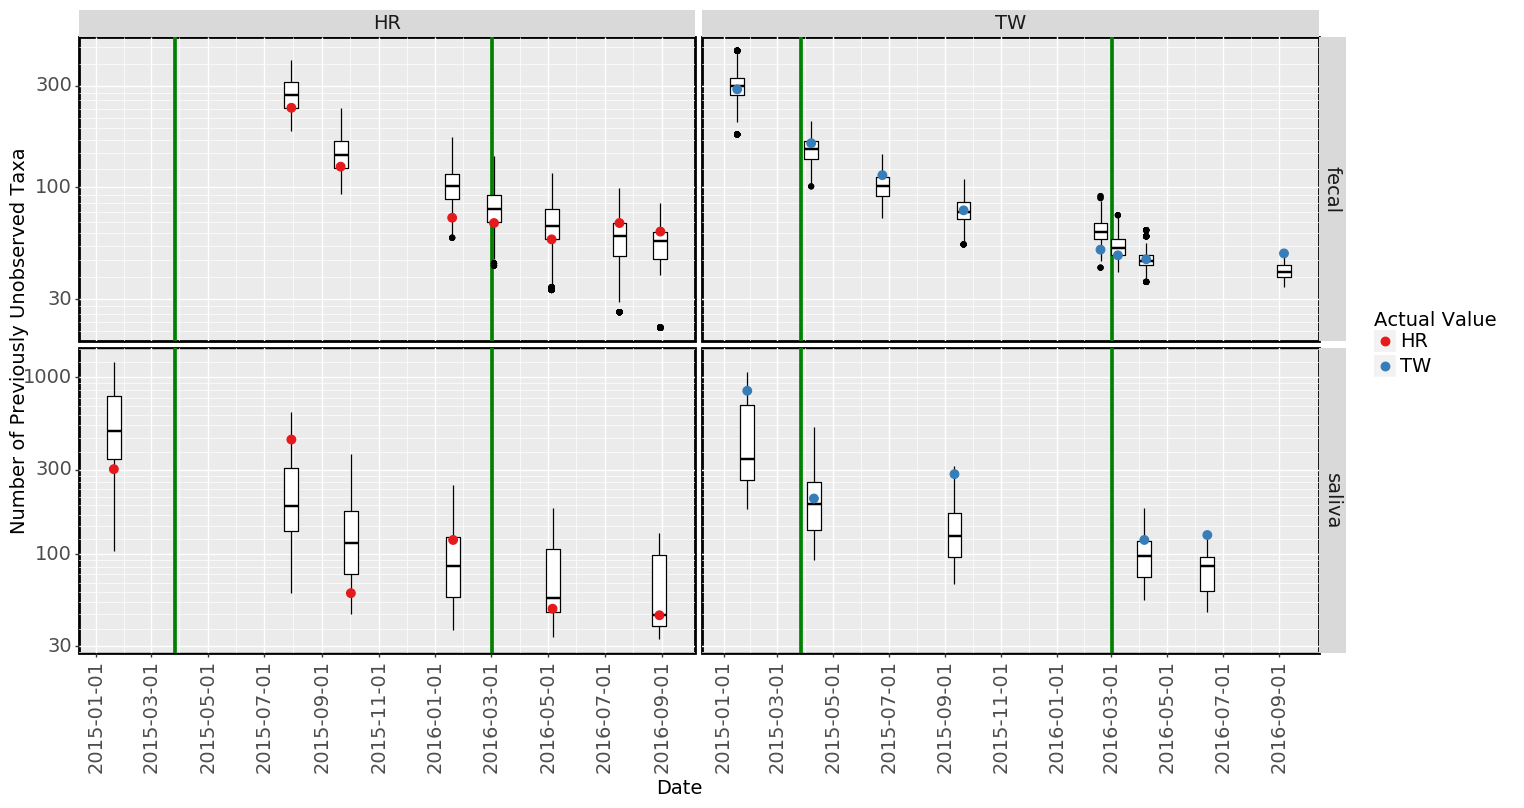

<ggplot: (-9223363279031548749)>

In [163]:
(
    ggplot(new_taxa_tbl, aes(x='order', y='value', color='subject')) +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-03-02', color='green', size=1.5) +
        facet_grid('kind~subject', scales='free') +
        geom_boxplot(width=15, data=new_taxa_tbl.query('variable != "Real Order"'), color='black') +
        geom_point(data=new_taxa_tbl.query('variable == "Real Order"'), size=3) +
        scale_y_log10() +
        scale_x_date() +
        scale_color_brewer(type='qualitative', palette=6, direction=1) +
        xlab(f'Date') +
        ylab(f'Number of Previously Unobserved Taxa') +
        labs(color='Actual Value') +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 8),
        )
)

In [154]:


def perm_test(subj, kind, new_taxa_tbl):
    tbl = new_taxa_tbl.query('subject == @subj').query('kind ==@kind')
    real = tbl.query('variable == "Real Order"')
    fake = tbl.query('variable != "Real Order"')
    
    inds = [2, 3, 4, 5]
    if kind == 'buccal':
        inds = [2, 3]
    elif kind == 'saliva' and subj == 'TW':
        inds = [2, 3]
    elif kind == 'saliva' and subj == 'HR':
        inds = [2, 3, 4]
    c = real.query('numeric_order in @inds').set_index('numeric_order')
    def compare(sub_tbl):
        t = sub_tbl.query('numeric_order in @inds').set_index('numeric_order')
        bigger = (t['value'] >= c['value']).sum() == len(inds)
        return bigger

    larger = fake.groupby('ovariable').apply(compare)
    return larger.mean()

test_ress = [
    perm_test('TW', 'fecal', new_taxa_tbl),
    perm_test('TW', 'saliva', new_taxa_tbl),
   # perm_test('TW', 'buccal', new_taxa_tbl),
    perm_test('HR', 'fecal', new_taxa_tbl),
    perm_test('HR', 'saliva', new_taxa_tbl),
    # perm_test('HR', 'buccal', new_taxa_tbl),
]
test_ress

[0.031, 0.018, 0.379, 0.014]

In [155]:
[1 - x for x in test_ress]

[0.969, 0.982, 0.621, 0.986]

In [141]:
env_taxa = figs.iss.taxa_read_counts()
env_taxa = taxa[set(taxa.columns) & set(env_taxa.columns)]

In [142]:
new_env_taxa_tbls = [
    get_new_taxa_tbl('TW', 'fecal', env_taxa),
    get_new_taxa_tbl('TW', 'buccal', env_taxa),
    get_new_taxa_tbl('TW', 'saliva', env_taxa),
    get_new_taxa_tbl('HR', 'fecal', env_taxa),
    get_new_taxa_tbl('HR', 'buccal', env_taxa),
    get_new_taxa_tbl('HR', 'saliva', env_taxa),
]
new_env_taxa_tbl = pd.concat(new_env_taxa_tbls)
new_env_taxa_tbl

,order,numeric_order,variable,value,ovariable,subject,kind
0,2015-01-16 00:00:00,1,Real Order,231,Real Order,TW,fecal
1,2015-04-07 00:00:00,2,Real Order,99,Real Order,TW,fecal
2,2015-06-24 00:00:00,3,Real Order,77,Real Order,TW,fecal
3,2015-09-21 00:00:00,4,Real Order,46,Real Order,TW,fecal
4,2016-02-18 00:00:00,5,Real Order,22,Real Order,TW,fecal
...,...,...,...,...,...,...,...
6001,2015-07-30 00:00:00,2,permutation,219,permutation_999,HR,saliva
6002,2015-10-02 00:00:00,3,permutation,196,permutation_999,HR,saliva
6003,2016-01-20 00:00:00,4,permutation,30,permutation_999,HR,saliva
6004,2016-05-06 00:00:00,5,permutation,44,permutation_999,HR,saliva


In [144]:
[
    perm_test('TW', 'fecal', new_env_taxa_tbl),
    perm_test('TW', 'saliva', new_env_taxa_tbl),
    perm_test('TW', 'buccal', new_env_taxa_tbl),
    perm_test('HR', 'fecal', new_env_taxa_tbl),
    perm_test('HR', 'saliva', new_env_taxa_tbl),
    perm_test('HR', 'buccal', new_env_taxa_tbl),
]

[0.025, 0.023, 0.161, 0.664, 0.017, 0.189]

In [146]:
[1 - x for x in [0.025, 0.023, 0.161, 0.664, 0.017, 0.189]]

[0.975, 0.977, 0.839, 0.33599999999999997, 0.983, 0.8109999999999999]

In [147]:
new_taxa_tbl

,order,numeric_order,variable,value,ovariable,subject,kind
0,2015-01-16 00:00:00,1,Real Order,288,Real Order,TW,fecal
1,2015-04-07 00:00:00,2,Real Order,161,Real Order,TW,fecal
2,2015-06-24 00:00:00,3,Real Order,114,Real Order,TW,fecal
3,2015-09-21 00:00:00,4,Real Order,78,Real Order,TW,fecal
4,2016-02-18 00:00:00,5,Real Order,51,Real Order,TW,fecal
...,...,...,...,...,...,...,...
6001,2015-07-30 00:00:00,2,permutation,178,permutation_999,HR,saliva
6002,2015-10-02 00:00:00,3,permutation,104,permutation_999,HR,saliva
6003,2016-01-20 00:00:00,4,permutation,57,permutation_999,HR,saliva
6004,2016-05-06 00:00:00,5,permutation,48,permutation_999,HR,saliva


In [167]:
def get_new_taxa_abundance_tbl(subject, kind, taxa):
    tw_real_order = meta.query('subject == @subject').query('kind == @kind')['date'].sort_values().index.to_list()
    tw_real_order = [el for el in tw_real_order if el in taxa.index]
    new_taxa_tbl = new_taxa(tw_real_order, taxa)
    new_taxa_tbl = pd.DataFrame.from_dict(new_taxa_tbl, orient='index')
    new_taxa_tbl = new_taxa_tbl.fillna(0)
    return new_taxa_tbl
    

def new_taxa(order, taxa):
    out = {}
    current_taxa = set()
    for i, sample_name in enumerate(order):
        try:
            sample_taxa = taxa.loc[sample_name]
        except KeyError:
            continue
        sample_taxa = set(sample_taxa[sample_taxa > 0].index.to_list())
        new_taxa = sample_taxa - current_taxa
        current_taxa |= sample_taxa
        out[i] = {x: 1 for x in new_taxa}
    return out


new_taxa_abunds = {
    ('TW', 'fecal'):    get_new_taxa_abundance_tbl('TW', 'fecal', taxa),
    ('TW', 'buccal'):    get_new_taxa_abundance_tbl('TW', 'buccal', taxa),
    ('TW', 'saliva'):    get_new_taxa_abundance_tbl('TW', 'saliva', taxa),
    ('HR', 'fecal'):    get_new_taxa_abundance_tbl('HR', 'fecal', taxa),
    ('HR', 'buccal'):    get_new_taxa_abundance_tbl('HR', 'buccal', taxa),
    ('HR', 'saliva'):    get_new_taxa_abundance_tbl('HR', 'saliva', taxa),
}

new_taxa_abunds[('TW', 'fecal')]

,d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Burkholderiales|f__Alcaligenaceae|g__Pelistega,d__Bacteria|p__Bacteroidetes|c__Flavobacteriia|o__Flavobacteriales|f__Flavobacteriaceae|g__Apibacter|s__Apibacter sp. B2966,d__Bacteria|p__Bacteroidetes|c__Bacteroidia|o__Bacteroidales|s__Bacteroidales bacterium CF,d__Bacteria|p__Cyanobacteria|o__Chroococcales|f__Aphanothecaceae|g__Candidatus Atelocyanobacterium|s__Candidatus Atelocyanobacterium thalassa,d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Oceanospirillales|f__Halomonadaceae|g__Halomonas|s__Halomonas sp. GT,d__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Frankiales|f__Frankiaceae|g__Frankia|s__Candidatus Frankia datiscae,d__Bacteria|p__Tenericutes|c__Mollicutes|o__Acholeplasmatales|f__Acholeplasmataceae|g__Acholeplasma|s__Acholeplasma laidlawii,d__Bacteria|p__Proteobacteria|c__Betaproteobacteria|o__Neisseriales|f__Neisseriaceae|g__Neisseria|s__Neisseria elongata,d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Myoviridae|g__Salmondvirus|s__Dickeya virus JA29,d__Bacteria|p__Firmicutes|c__Bacilli|o__Lactobacillales|f__Lactobacillaceae|g__Lactobacillus|s__Lactobacillus terrae,...,d__Archaea|p__Crenarchaeota|c__Thermoprotei|o__Desulfurococcales|f__Desulfurococcaceae|g__Thermosphaera,d__Viruses|k__Orthornavirae|p__Pisuviricota|c__Pisoniviricetes|o__Picornavirales|f__Picornaviridae|g__Megrivirus,d__Viruses|k__Bamfordvirae|p__Nucleocytoviricota|c__Megaviricetes|o__Algavirales|f__Phycodnaviridae|g__Prasinovirus,d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Siphoviridae|g__Kagunavirus|s__Escherichia virus K1ind1,d__Bacteria|p__Proteobacteria|c__Gammaproteobacteria|o__Enterobacterales|f__Enterobacteriaceae|g__Salmonella|s__Salmonella sp. SCFS4,d__Eukaryota|c__Cryptophyceae|o__Cryptomonadales|f__Cryptomonadaceae|g__Cryptomonas|s__Cryptomonas paramecium,d__Bacteria|p__Proteobacteria|c__Epsilonproteobacteria|o__Campylobacterales|f__Helicobacteraceae|g__Helicobacter|s__Helicobacter acinonychis,d__Viruses|p__Peploviricota|c__Herviviricetes|o__Herpesvirales|f__Herpesviridae|g__Mardivirus,d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Siphoviridae|g__Skunavirus|s__Lactococcus virus bIL170,d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Myoviridae|g__Radnorvirus|s__Arthrobacter virus ArV1
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [169]:

env_total_prop_tbl = {}
for i, t in new_taxa_abunds.items():
    overall = t.sum(axis=1)
    env = t[set(env_taxa.columns) & set(t.columns)].sum(axis=1)
    env_total_prop_tbl[i] = env / overall
    
env_total_prop_tbl = pd.DataFrame.from_dict(env_total_prop_tbl, orient='index')
env_total_prop_tbl *= 100
env_total_prop_tbl

0          1          2          3          4          5  \
TW fecal   97.900955  80.208333  61.490683  67.543860  58.974359  43.137255   
   buccal  98.371777  93.721286  92.553191  82.255390        NaN        NaN   
   saliva  98.239389  85.799523  63.592233  69.611307  52.500000  57.812500   
HR fecal   97.641624  59.322034  51.200000  52.777778  50.000000  56.140351   
   buccal  98.802783  94.489465  92.164179  88.000000  88.444444  85.915493   
   saliva  97.772054  82.450331  77.027027  60.000000  55.000000  61.224490   

                   6          7          8  
TW fecal   52.083333  52.173913  57.142857  
   buccal        NaN        NaN        NaN  
   saliva        NaN        NaN        NaN  
HR fecal   50.000000  43.548387        NaN  
   buccal        NaN        NaN        NaN  
   saliva  48.888889        NaN        NaN

In [172]:
env_total_prop_tbl[[2, 3, 4]].mean(axis=1)

TW  fecal     62.669634
    buccal    87.404291
    saliva    61.901180
HR  fecal     51.325926
    buccal    89.536208
    saliva    64.009009
dtype: float64

In [2]:
meta = figs.metadata()
# meta['kind'] = meta['kind'].map(lambda x: 'oral' if x in ['buccal', 'saliva'] else x)
twins_taxa = figs.twins.taxa_read_counts()
iss_taxa = figs.iss.taxa_read_counts()
meta

,date,pma_treated,kind,subject,flight,during_flight,time_label
011515_TW_B,2015-01-15,False,buccal,TW,before,before,before
011515_TW_S,2015-01-15,False,saliva,TW,before,before,before
012015_HR_B,2015-01-20,False,buccal,HR,ground,before,before
012015_HR_S,2015-01-20,False,saliva,HR,ground,before,before
012016_HR_B,2016-01-20,False,buccal,HR,ground,flight,flight
...,...,...,...,...,...,...,...
IIIF3SW,2016-05-06,False,Surface,ISS,NaN,NaN,unknown
IIIF8SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown
IIIF5SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown
IIIF3SW_P,2016-05-06,True,Surface,ISS,NaN,NaN,unknown


In [65]:
PRE_READ_CUTOFF = 1
READ_CUTOFF = 10
MIN_N_SAMPLES = 2

twins_env_taxa = twins_taxa[set(twins_taxa.columns) & set(iss_taxa.columns)]
twins_env_taxa = twins_env_taxa.fillna(0)
twins_env_taxa['flight'] = meta.loc[twins_env_taxa.index, 'flight']

twins_env_taxa['kind'] = meta.loc[twins_env_taxa.index, 'kind']
twins_env_taxa = twins_env_taxa.query('kind != "buccal"')
twins_env_taxa = twins_env_taxa.dropna()
twins_env_taxa = twins_env_taxa.drop(columns=['kind'])

tw_env_taxa = twins_env_taxa.query('flight != "ground"')
preflight_taxa = (tw_env_taxa.query('flight == "before"').drop(columns=['flight']) >= PRE_READ_CUTOFF).sum()
preflight_taxa = preflight_taxa[preflight_taxa > 0].index.to_list()
flight_taxa = set(tw_env_taxa.columns) - set(preflight_taxa)
print(len(flight_taxa))

tw_flight_taxa = tw_env_taxa[flight_taxa]
tw_flight_taxa = tw_flight_taxa.drop(columns=['flight'])
tw_flight_taxa = (tw_flight_taxa >= READ_CUTOFF).sum()
tw_flight_taxa = tw_flight_taxa[tw_flight_taxa >= MIN_N_SAMPLES]
print(tw_flight_taxa.shape)
# tw_flight_taxa = tw_flight_taxa[[('s__' in el) for el in tw_flight_taxa.index]]

print(tw_flight_taxa.shape)
tw_flight_taxa

522
(5,)
(5,)


d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Siphoviridae|s__Streptococcus phage phiARI0004                    2
d__Bacteria|p__Proteobacteria|c__Alphaproteobacteria|o__Rickettsiales|f__Rickettsiaceae|g__Rickettsia|s__Rickettsia australis    3
d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Myoviridae|s__Xanthomonas phage vB_XveM_DIBBI                     2
d__Viruses|k__Bamfordvirae|p__Nucleocytoviricota|c__Pokkesviricetes|o__Chitovirales|f__Poxviridae|g__Orthopoxvirus               2
d__Viruses|p__Uroviricota|c__Caudoviricetes|o__Caudovirales|f__Myoviridae|g__Emdodecavirus                                       2
dtype: int64

In [66]:
tw_flight_taxa = tw_env_taxa[tw_flight_taxa.index].fillna(0)
tw_flight_taxa.columns = tw_flight_taxa.columns.map(lambda x: x.split('__')[-1])
tw_flight_taxa['flight'] = meta.loc[tw_flight_taxa.index, 'flight']
tw_flight_taxa['date'] = meta.loc[tw_flight_taxa.index, 'date']
tw_flight_taxa['kind'] = meta.loc[tw_flight_taxa.index, 'kind']
tw_flight_taxa = tw_flight_taxa.rename(columns={
    'Streptococcus phage phiARI0004': 'Streptococcus phage',
    'Xanthomonas phage vB_XveM_DIBBI': 'Xanthomonas phage'
})
tw_flight_taxa = tw_flight_taxa.melt(id_vars=['flight', 'date', 'kind'])
tw_flight_taxa = tw_flight_taxa.dropna()
tw_flight_taxa = tw_flight_taxa.query('kind != "buccal"')
tw_flight_taxa

,flight,date,kind,variable,value
0,before,2015-01-15,saliva,Streptococcus phage,0.0
1,before,2015-01-27,saliva,Streptococcus phage,0.0
2,after,2016-04-06,saliva,Streptococcus phage,45.0
3,flight,2015-04-10,saliva,Streptococcus phage,11.0
4,after,2016-06-14,saliva,Streptococcus phage,2.0
...,...,...,...,...,...
70,flight,2015-06-24,fecal,Emdodecavirus,0.0
71,flight,2015-09-21,fecal,Emdodecavirus,0.0
72,after,2016-03-08,fecal,Emdodecavirus,0.0
73,after,2016-04-08,fecal,Emdodecavirus,0.0


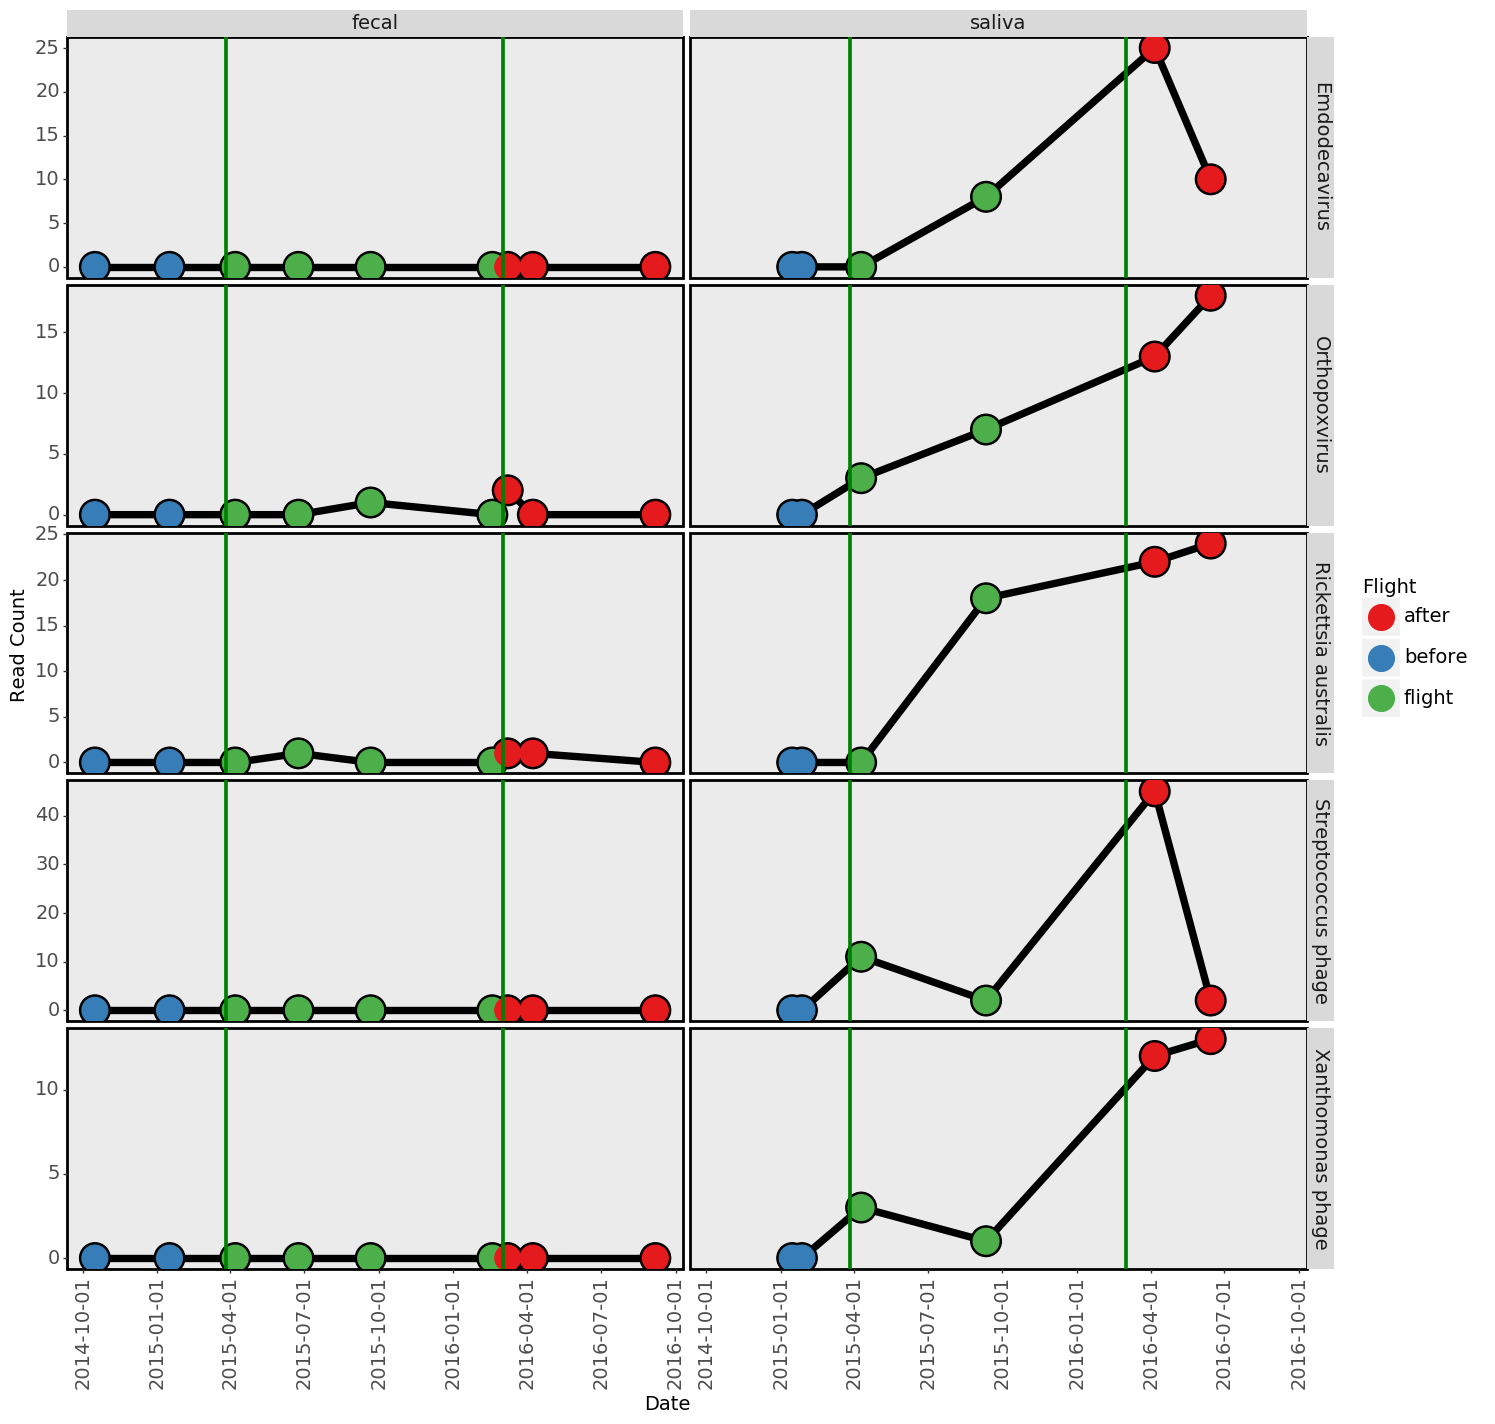

<ggplot: (8757822742855)>

In [164]:

(
    ggplot(tw_flight_taxa, aes(x='date', y='value', color='flight')) +
        geom_line(color='black', size=3) +
        geom_point(size=12, colour="black") +
        geom_point(size=10) +
        facet_grid('variable~kind', scales='free_y') +
        #theme_minimal() +
        scale_x_date() +
        scale_color_brewer(type='qualitative', palette=6, direction=1) +
        #theme_minimal() +
        xlab(f'Date') +
        ylab(f'Read Count') +
        labs(color='Flight', shape='Kind') +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-03-02', color='green', size=1.5) +
        theme(
            text=element_text(size=14),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 16),
        )
)    


In [81]:
taxa = pd.concat([
    figs.twins.taxa_read_counts(),
    figs.iss.taxa_read_counts(),
]).fillna(0)
taxa

,d__Archaea,d__Archaea|p__Candidatus Korarchaeota,d__Archaea|p__Candidatus Korarchaeota|g__Candidatus Korarchaeum,d__Archaea|p__Candidatus Korarchaeota|g__Candidatus Korarchaeum|s__Candidatus Korarchaeum cryptofilum,d__Archaea|p__Candidatus Lokiarchaeota,d__Archaea|p__Candidatus Lokiarchaeota|g__Candidatus Prometheoarchaeum,d__Archaea|p__Candidatus Lokiarchaeota|g__Candidatus Prometheoarchaeum|s__Candidatus Prometheoarchaeum syntrophicum,d__Archaea|p__Candidatus Micrarchaeota,d__Archaea|p__Candidatus Micrarchaeota|g__Candidatus Mancarchaeum,d__Archaea|p__Candidatus Micrarchaeota|g__Candidatus Mancarchaeum|s__Candidatus Mancarchaeum acidiphilum,...,d__Viruses|s__Wuhan heteroptera virus 3,d__Viruses|s__Wuhan insect virus 19,d__Viruses|s__Wuhan spider virus 2,d__Viruses|s__Wuhan spider virus 6,d__Viruses|s__Xingshan nematode virus 2,d__Viruses|s__narna-like virus 6,d__Viruses|s__uncultured Mediterranean phage,s__Plasmid pAM77,s__Plasmid pIP1527,s__Plasmid pUB110
011515_TW_B,397.0,0.0,0.0,0.0,4.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
011515_TW_S,495.0,0.0,0.0,0.0,8.0,8.0,8.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
012015_HR_B,205.0,0.0,0.0,0.0,3.0,3.0,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
012015_HR_S,506.0,0.0,0.0,0.0,12.0,12.0,12.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
012016_HR_S,1148.0,0.0,0.0,0.0,14.0,14.0,14.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IIIF3SW,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IIIF8SW_P,784.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IIIF5SW_P,667.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
IIIF3SW_P,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [272]:

def get_preceding_samples(sample_name, subject, kind, taxa):
    ref_date = meta.loc[sample_name, 'date']
    sample_names = meta
    if kind != 'ISS':
        sample_names = sample_names.query('subject == @subject').query('kind == @kind')
    else:
        sample_names = sample_names.query('subject == @kind')
    sample_names = sample_names.query('date < @ref_date').index.to_list()
    sample_names = [el for el in sample_names if el in taxa.index]
    return sample_names


def taxa_set(sample_names, taxa):
    taxa = taxa.loc[sample_names]
    taxa_set = taxa.sum()
    taxa_set = taxa_set[taxa_set > 0]
    taxa_set = set(taxa_set.index)
    return taxa_set


def get_taxa_sources(sample_name, subject, kind, taxa):
    ref_taxa = taxa_set([sample_name], taxa)
    mykinds = ['Fecal', 'Mixed', 'Saliva', 'ISS']
    if kind == 'saliva':
        mykinds = ['Saliva', 'Mixed', 'Fecal', 'ISS']
    
    out = {}
    for mykind in mykinds:
        if mykind == 'Mixed':
            preceding_samples = get_preceding_samples(sample_name, subject, 'ISS', taxa)
            preceding_taxa = taxa_set(preceding_samples, taxa)
            if kind == 'fecal':
                preceding_samples = get_preceding_samples(sample_name, subject, 'saliva', taxa)
            elif kind == 'saliva':
                preceding_samples = get_preceding_samples(sample_name, subject, 'fecal', taxa)
            preceding_taxa &= taxa_set(preceding_samples, taxa)
        else:
            preceding_samples = get_preceding_samples(sample_name, subject, mykind if mykind == 'ISS' else mykind.lower(), taxa)
            preceding_taxa = taxa_set(preceding_samples, taxa)
        out[mykind] = len(ref_taxa & preceding_taxa)
        ref_taxa -= preceding_taxa
    out['Unidentified'] = len(ref_taxa)
    return out

def _postprocess_table(tbl):
    tbl['sample_name'] = tbl.index
    tbl['date'] = meta.loc[tbl.index, 'date']
    tbl['subject'] = meta.loc[tbl.index, 'subject']
    tbl['kind'] = meta.loc[tbl.index, 'kind']
    tbl['flight'] = meta.loc[tbl.index, 'flight']
    tbl['during_flight'] = meta.loc[tbl.index, 'during_flight']
    tbl = tbl.melt(id_vars=['sample_name', 'date', 'subject', 'kind', 'flight', 'during_flight'])
    tbl['varlow'] = tbl['variable'].map(lambda x: x.lower())
    return tbl

def get_taxa_source_table(subject, kind, taxa):
    sample_order = meta.query('subject == @subject').query('kind == @kind')['date'].sort_values().index.to_list()
    sample_order = [el for el in sample_order if el in taxa.index]
    print(sample_order)
    sample_order = sample_order[1:]  # first sample uninteresting
    #sample_order = sample_order[1:]  # second sample uninteresting
    tbl = {
        sample_name: get_taxa_sources(sample_name, subject, kind, taxa)
        for sample_name in sample_order
    }
    tbl = pd.DataFrame.from_dict(tbl, orient='index')
    tbl = _postprocess_table(tbl)
    return tbl

taxa_sources = pd.concat([
    get_taxa_source_table('TW', 'fecal', taxa),
    get_taxa_source_table('TW', 'saliva', taxa),
    get_taxa_source_table('HR', 'fecal', taxa),
    get_taxa_source_table('HR', 'saliva', taxa),
])
taxa_sources


['MHV-TW1_S41667392', 'MHV-TW2_S41668201', 'MHV-TW3_S41666352', 'MHV-TW5_S41659412', 'MHV-TW6_S41671226', 'MHV-TW4_S41665304', 'MHV-TW7_S41665306', 'MHV-TW8_S41663403', 'MHV-TW9_S41659413']
['011515_TW_S', '012715_TW_S', '041015_TW_S', '091115_TW_S', '040616_TW_S', '061416_TW_S']
['MHV-HR2_S41666347', 'MHV-HR3_S41658400', 'MHV-HR4_S41677053', 'MHV-HR5_S41659407', 'MHV-HR6_S41664399', 'MHV-HR7_S41668198', 'MHV-HR8_S41669183', 'MHV-HR9_S41667391']
['120314_HR_S', '012015_HR_S', '073015_HR_S', '100215_HR_S', '012016_HR_S', '050616_HR_S', '082916_HR_S']


,sample_name,date,subject,kind,flight,during_flight,variable,value,varlow
0,MHV-TW2_S41668201,2015-01-16,TW,fecal,before,before,Fecal,7693,fecal
1,MHV-TW3_S41666352,2015-04-07,TW,fecal,flight,flight,Fecal,7802,fecal
2,MHV-TW5_S41659412,2015-06-24,TW,fecal,flight,flight,Fecal,7875,fecal
3,MHV-TW6_S41671226,2015-09-21,TW,fecal,flight,flight,Fecal,7983,fecal
4,MHV-TW4_S41665304,2016-02-18,TW,fecal,flight,flight,Fecal,7887,fecal
...,...,...,...,...,...,...,...,...,...
25,073015_HR_S,2015-07-30,HR,saliva,ground,flight,Unidentified,83,unidentified
26,100215_HR_S,2015-10-02,HR,saliva,ground,flight,Unidentified,21,unidentified
27,012016_HR_S,2016-01-20,HR,saliva,ground,flight,Unidentified,44,unidentified
28,050616_HR_S,2016-05-06,HR,saliva,ground,after,Unidentified,13,unidentified


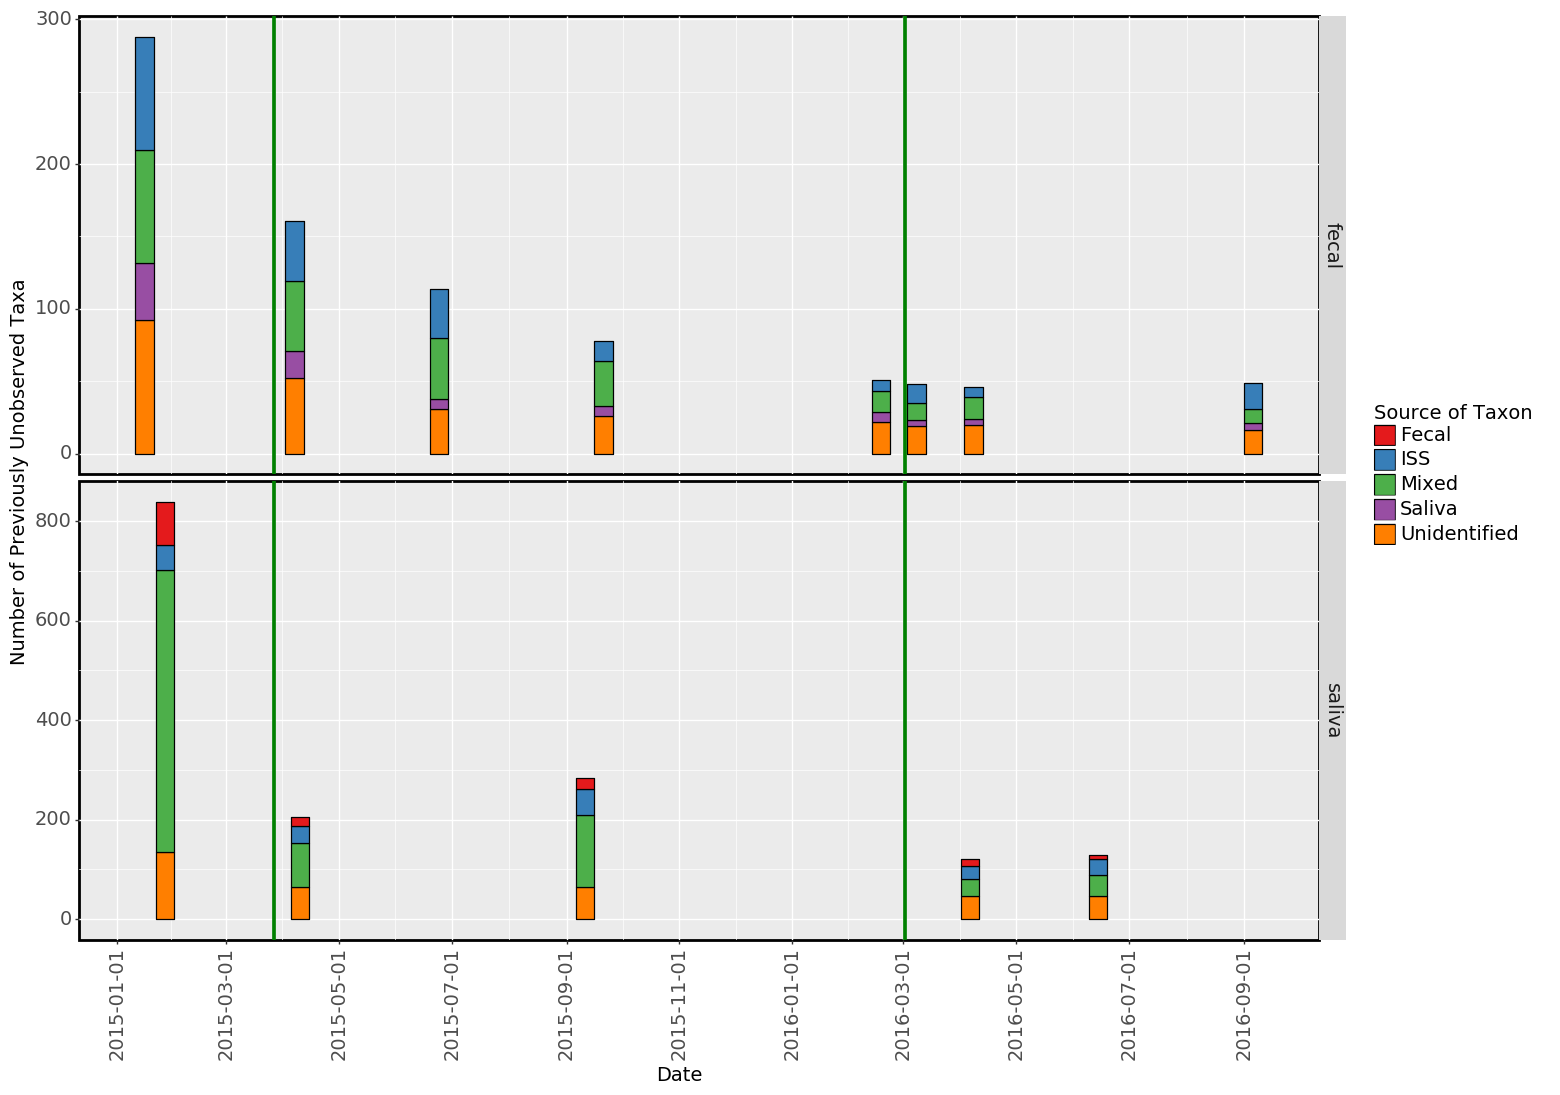

<ggplot: (8757821324236)>

In [273]:
t = taxa_sources.copy()
t = t.query('kind != varlow')
t = t.query('subject == "TW"')
(
    ggplot(t, aes(x='date', y='value', fill='variable')) +
        geom_col(color='black', width=10) +
        facet_grid('kind~.', scales='free') +
        scale_x_date() +
        scale_fill_brewer(type='qualitative', palette=6, direction=1) +
        xlab(f'Date') +
        ylab(f'Number of Previously Unobserved Taxa') +
        labs(fill='Source of Taxon') +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-03-02', color='green', size=1.5) +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)

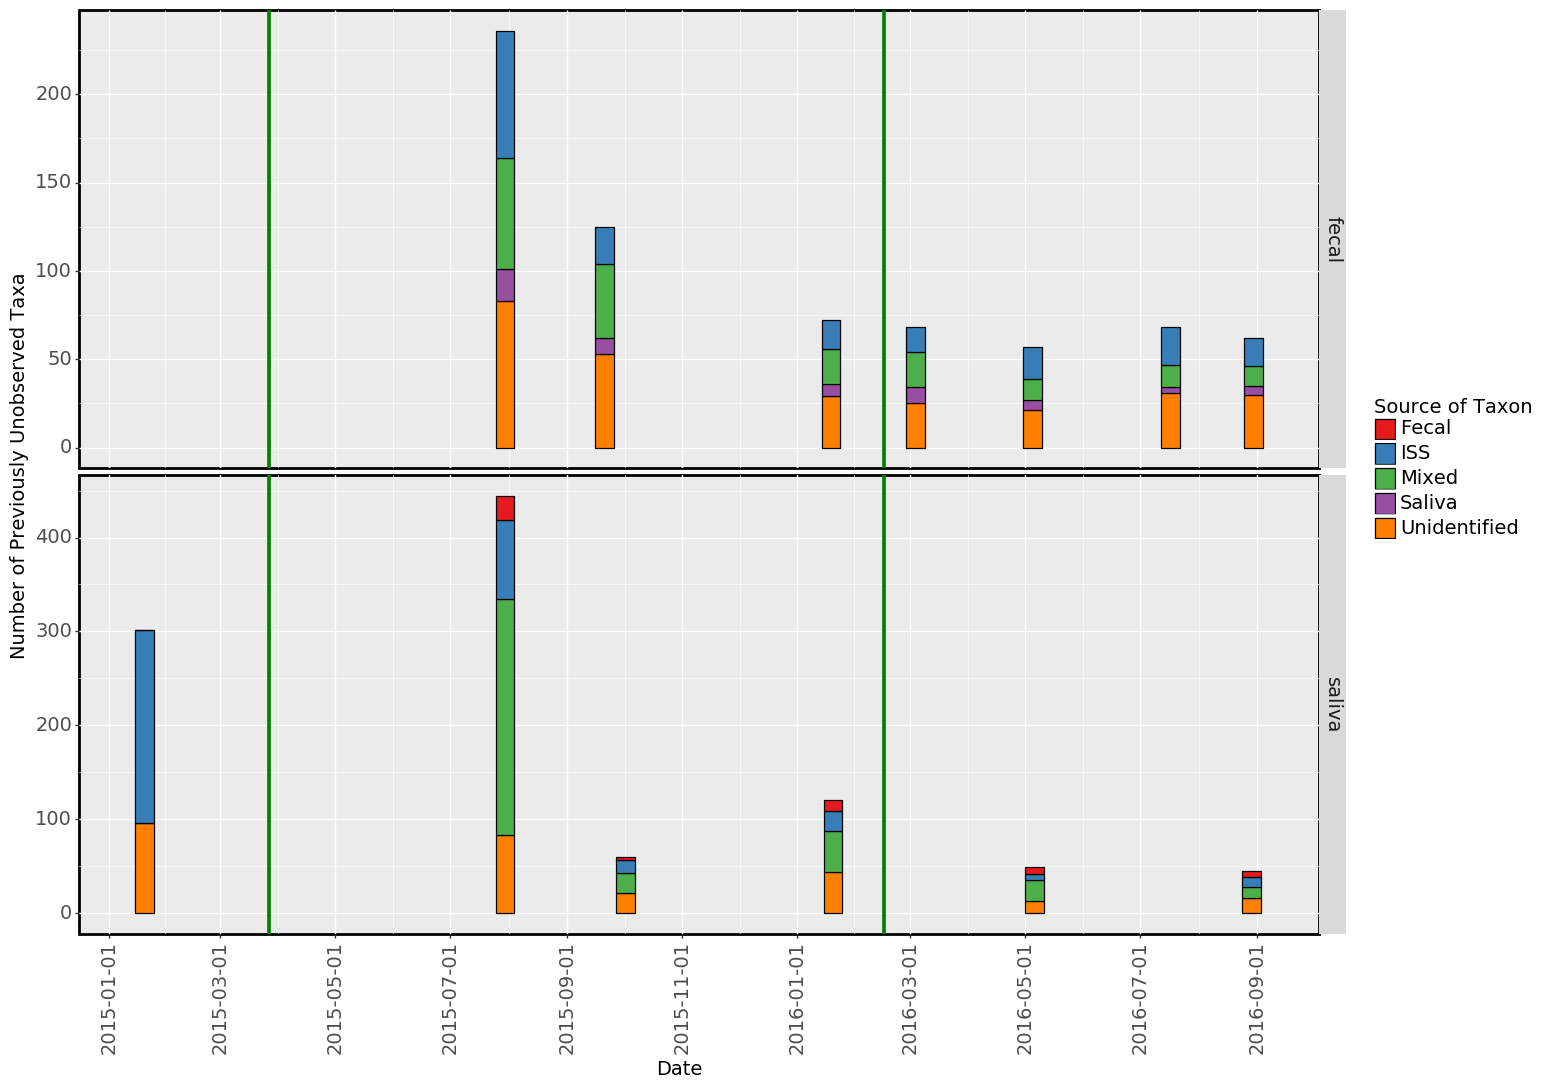

<ggplot: (8757819809400)>

In [274]:
t = taxa_sources.copy()
t = t.query('kind != varlow')
t = t.query('subject == "HR"')
(
    ggplot(t, aes(x='date', y='value', fill='variable')) +
        geom_col(color='black', width=10) +
        facet_grid('kind~.', scales='free') +
        scale_x_date() +
        scale_fill_brewer(type='qualitative', palette=6, direction=1) +
        xlab(f'Date') +
        ylab(f'Number of Previously Unobserved Taxa') +
        labs(fill='Source of Taxon') +
        geom_vline(xintercept='2015-03-27', color='green', size=1.5) +
        geom_vline(xintercept='2016-02-16', color='green', size=1.5) +
        theme(
            text=element_text(size=14),
            axis_text_x=element_text(angle=90),
            legend_position='right',
            panel_border=element_rect(colour="black", fill='none', size=2),
            figure_size=(16, 12),
        )
)

In [316]:
def norm_count(tbl):
    t = tbl.copy().query('varlow != kind')
    denom = t['value'].sum()
    t['norm_value'] = t['value'] / denom
    return t

normed_sources = taxa_sources.groupby(('date', 'subject', 'kind')).apply(norm_count)
#normed_sources = normed_sources.reset_index()

myvars = ['ISS', 'Mixed']
flight = normed_sources.query('kind == "fecal"').query('variable in @myvars').query('flight == "flight"').groupby('sample_name').sum()['norm_value']
non_flight = normed_sources.query('kind == "fecal"').query('variable in @myvars').query('flight != "flight"').groupby('sample_name').sum()['norm_value']

print(flight.mean(), non_flight.mean())
scipy.stats.ttest_ind(flight, non_flight, equal_var=True)

0.558492125947369 0.5136384545218454


Ttest_indResult(statistic=1.3210644007202834, pvalue=0.20926171038360133)

In [312]:

myvars = ['ISS', 'Mixed']
flight = normed_sources.query('kind == "saliva"').query('variable in @myvars').query('flight == "flight"').groupby('sample_name').sum()['norm_value']
non_flight = normed_sources.query('kind == "saliva"').query('variable in @myvars').query('flight != "flight"').groupby('sample_name').sum()['norm_value']

scipy.stats.ttest_ind(flight, non_flight, equal_var=True)

Ttest_indResult(statistic=0.4466808997944432, pvalue=0.6656600957252118)

In [335]:
sources = normed_sources.query('subject == "TW"').reset_index(drop=True).groupby(('kind', 'variable')).mean()['norm_value'].unstack().T
sources *= 100

print(sources.to_latex())

\begin{tabular}{lrr}
\toprule
kind &      fecal &     saliva \\
variable     &            &            \\
\midrule
Fecal        &        NaN &   8.688487 \\
ISS          &  24.458158 &  17.623487 \\
Mixed        &  29.868817 &  44.575200 \\
Saliva       &  10.220425 &        NaN \\
Unidentified &  35.452601 &  29.112827 \\
\bottomrule
\end{tabular}



In [228]:
hr_flight.mean()

0.5253446327683616

In [229]:
hr_non_flight.mean()

0.4904499151103565

In [209]:
flight

date        subject  kind     
2015-04-07  TW       fecal  17    0.260870
2015-06-24  TW       fecal  18    0.298246
2015-09-21  TW       fecal  19    0.179487
2016-02-18  TW       fecal  20    0.156863
Name: norm_value, dtype: float64

In [210]:
non_flight

date        subject  kind     
2015-01-16  TW       fecal  16    0.270833
2016-03-08  TW       fecal  21    0.270833
2016-04-08  TW       fecal  22    0.152174
2016-09-06  TW       fecal  23    0.367347
Name: norm_value, dtype: float64

In [213]:
hr

date        subject  kind     
2015-07-30  HR       fecal  14    0.305085
2015-09-21  HR       fecal  15    0.168000
2016-01-19  HR       fecal  16    0.222222
2016-03-04  HR       fecal  17    0.205882
2016-05-05  HR       fecal  18    0.315789
2016-07-17  HR       fecal  19    0.308824
2016-08-30  HR       fecal  20    0.258065
Name: norm_value, dtype: float64